# Generative Dog Images
*A GAN machine learning project* 

## OVERVIEW 
Creating artifical images is an exciting concept in the machine learning community. This competition was aimed to give new data scientists the ability to practice and learn how to create their first artifical images using Generative Adversial Network (GAN) models. This notebook is to practice keys skills and learn how GANs work using real images of dogs. Essentially, we have two neural networks - a generator which generates fake images and a discriminator which tries to always say which images are real and which are fake. As the generator learns, it will create better and better images and (hopefully) start to fool the discriminator into thinking its images are real. Our goal is to generate images which are real enough that it can convince the discriminator as such as well. 

Structure of this notebook:
1. Description of the problem and data
2. Exploratory data analysis (EDA) 
3. Analysis - model building and training
4. Result 
5. Conclusion

In [1]:
#import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, zipfile
import seaborn as sns
import cv2
import random
import os
import xml.etree.ElementTree as ET 
import PIL
from PIL import Image
import time
import shutil
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED = tf.random.set_seed(49)

2022-09-20 16:48:55.713418: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-20 16:48:55.713540: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Description of the problem and data

The goal of this competition is to be able to confuse the computer into thinking our generated images are real. We are given two zipped folders, 'Annotation' and 'all-dogs'. Annotation contains the class labels and bounding boxes for the images. All-dogs contains the images. Images are initially different sizes. We are not given a dataframe to view or plot values. Instead, we will move on to the EDA and view some images. Prior to training, we will set our training data (images) as "train_images" and we will normalize all images.

In [2]:
#get filenames
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


In [3]:
#set directory and unzip folders
if not os.path.exists('generative-dog-images'):
    !mkdir /kaggle/working/generative-dog-images
!unzip /kaggle/input/generative-dog-images/all-dogs.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1
!unzip /kaggle/input/generative-dog-images/Annotation.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1

In [4]:
#set directories and paths
all_dogs_dir = '/kaggle/working/generative-dog-images/all-dogs/'
annotation_dir = '/kaggle/working/generative-dog-images/Annotation/'

IMAGES = os.listdir(all_dogs_dir)
BREEDS = os.listdir(annotation_dir)

In [5]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

2022-09-20 16:49:18.800923: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-20 16:49:18.804058: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-20 16:49:18.804094: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 16:49:18.804123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5e43e9f05cf7): /proc/driver/nvidia/version does not exist
2022-09-20 16:49:18.807940: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [6]:
print('Dog Count:', len(os.listdir(all_dogs_dir)))
print('Breed Count:', len(os.listdir(annotation_dir)))

Dog Count: 20579
Breed Count: 120


# 2. Exploratory data analysis (EDA) 
We will crop the images to the bounding boxes and save them. Each image prior to crop and after will be a different size based on the bounding box and original image size. Then we will resize the images to be 100x100 pixels with 3 color channels. After cropping the images, we visualize them below. 

In [7]:
# Crop to bounding boxes such that we only have the dog(s) in the picture
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
idxIn = 0
namesIn = []
imagesIn = np.zeros((25000,100,100,3))

for breed in BREEDS: 
    for dog in os.listdir(annotation_dir+breed):
        try: img = Image.open(all_dogs_dir+dog+'.jpg') #open image
        except: continue           
        tree = ET.parse(annotation_dir+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects: #bounding box
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w)) #crop to bounding box
            img2 = img2.resize((100,100), Image.ANTIALIAS) #resize to 100x100
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1
idx = np.arange(idxIn)
np.random.shuffle(idx)
imagesIn = imagesIn[idx,:,:,:]
namesIn = np.array(namesIn)[idx]

In [8]:
#delete files now that we have images 
# and names files to make room
shutil.rmtree(all_dogs_dir)
shutil.rmtree(annotation_dir)

In [9]:
#view array shape (make sure images are 100x100x3)
imagesIn.shape

(22125, 100, 100, 3)

In [10]:
namesIn.shape

(22125,)

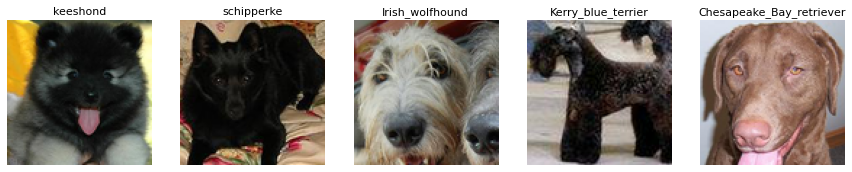

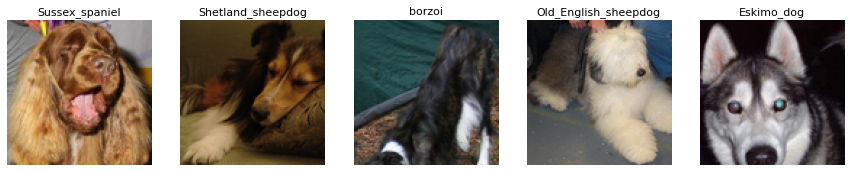

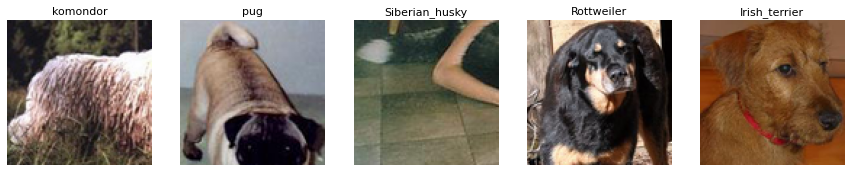

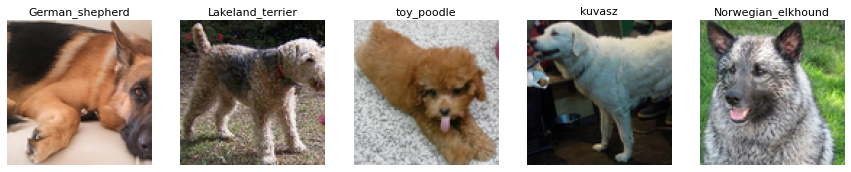

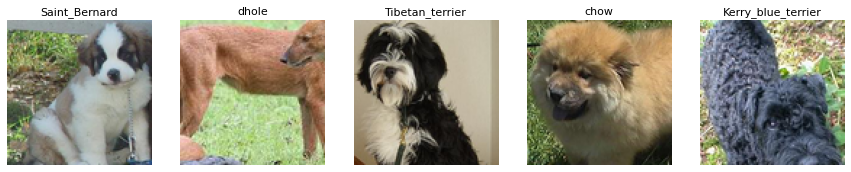

In [11]:
# visualize cropped images
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

In [14]:
# normalize to [-1, 1]
train_images = imagesIn / 127.5 - 127.5
del imagesIn  
train_images.shape

(22125, 100, 100, 3)

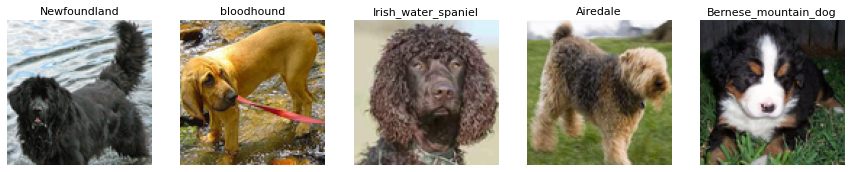

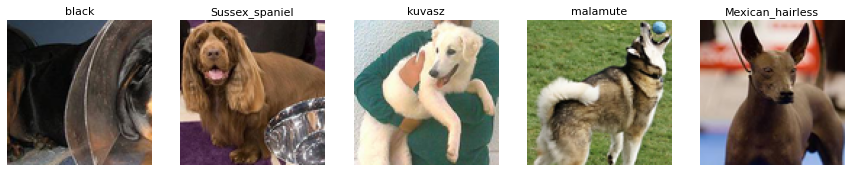

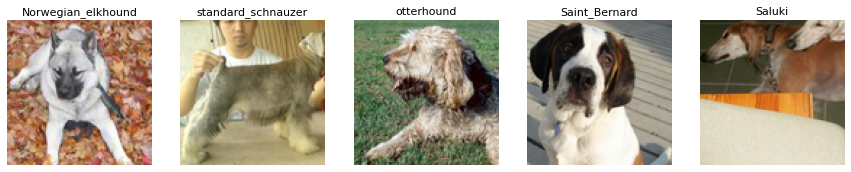

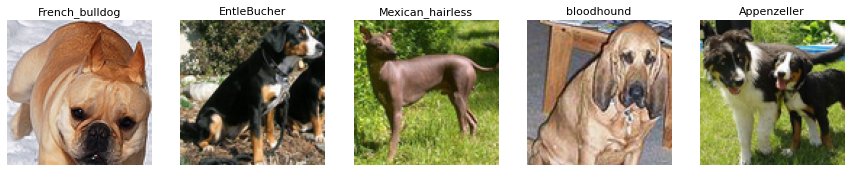

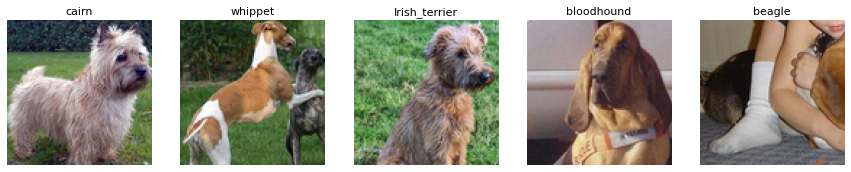

In [15]:
# Make sure we can return to 'normal' color fotos after having normalized
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray((train_images[x[k*5+j],:,:,:]*127.5 +127.5).astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

# 3. Analysis - model building and training

Now for the fun part! We will begin to train our GAN model. We have cropped and normalized our data above, which is what we will use in the model. We will declare two models: generator and discriminator. The generator will create images and try to "trick" the discriminator. The discriminator will decide which images are real or fake. Our goal is to fool the discriminator such that it thinks our generated images are actually real. We will use 200 epochs, which we hope will be enough to train the models. Next, we will create 16 images per epoch so that we can see what the generator is creating. Our generator will have multiple layers using activation functions such as ReLU and Leaky ReLU. Leaky ReLU will help the function from becoming saturated at 0. 

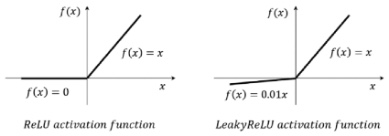

https://www.researchgate.net/figure/ReLU-activation-function-vs-LeakyReLU-activation-function_fig2_358306930

We will also use dropout layers which randomly sets input units to 0 during each training step. We will use batch normalization which normalizes its inputs by keeping the mean close to 0. In the generator model, we will use 3 as our output so that we have 3 color channels, and we will use a 'tanh' activation function which gives higher gradient values during training and more weight changes in network. In the discriminator, we will use 1 so that we have a yes/no type of response (is or isn't real), and we will use a linear activation function. As suggested by other Kagglers. For our loss functions, we will use Binary Cross Entropy. When compiling the models, we will use the Adam optimizer with a learning rate of 0.0001.

In [16]:
# set globals for training
EPOCHS = 100 
NOISE_DIM = 100
BATCH_SIZE = 256
LATENT_DIM = 100*100*3 
ONES = np.ones(BATCH_SIZE)
ZEROS = np.zeros(BATCH_SIZE)

In [17]:
#reshape images for model
train_images = train_images.reshape(-1, 100*100*3)
train_images.shape

(22125, 30000)

In [39]:
#build generator model
def create_generator(latentDim):
    with strategy.scope():

        inputs = Input(shape=(latentDim, ))
        gen = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(inputs) 
        gen = layers.BatchNormalization(momentum=0.8)(gen) 
        gen = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = layers.Dense(1024, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = Dense(100*100*3, activation='tanh')(gen)
        model = Model(inputs, gen)
        return model

In [40]:
#build discriminator model
def create_discriminator(image_size):
    with strategy.scope():

        inputs = Input(shape=(image_size, ))
        disc = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(inputs)
        disc = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(disc)
        disc = layers.Dense(1, activation='sigmoid')(disc)
        model = Model(inputs, disc)
        return model

In [41]:
with strategy.scope():

    #build discriminator 
    discriminator = create_discriminator(100*100*3) 
    discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                          optimizer=tf.keras.optimizers.Adam(0.0001), 
                          metrics=['accuracy'])

In [42]:
#build combined model
generator = create_generator(LATENT_DIM)

In [43]:
print(' ############## GENERATOR MODEL ##############')
generator.summary()
print('\n', '############## DISCRIMINATOR MODEL ##############')
discriminator.summary()

 ############## GENERATOR MODEL ##############
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30000)]           0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               7680256   
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normal

Prediction =  tf.Tensor([[0.4846681]], shape=(1, 1), dtype=float32)


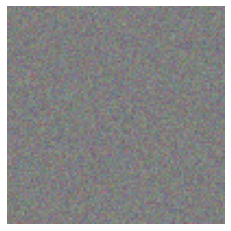

In [44]:
#visualize example and make sure its working correct
noise = tf.random.normal([1, LATENT_DIM])
image = generator(noise)
discriminator.trainable = False
prediction = discriminator(image)
image = (tf.reshape(image, (100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
plt.imshow(image);
plt.axis('off')
print("Prediction = ", prediction)

In [45]:
with strategy.scope():

    #compile model completely using noise image as our starting point
    noise = Input(shape=(LATENT_DIM, ))
    image = generator(noise)
    prediction = discriminator(image)

    GAN = Model(noise, prediction) 

    GAN.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                          optimizer=tf.keras.optimizers.Adam(0.0001))

In [46]:
#create folder to save generator images
if not os.path.exists('GAN_images'):
    os.makedirs('GAN_images')

In [47]:
#produce sample images
def sample_images(epoch):
    rows = 5
    cols = 5
    noise = np.random.randn(rows*cols, LATENT_DIM)
    images = generator.predict(noise)
    images = (tf.reshape(images, (images.shape[0], 100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
    fig, axs = plt.subplots(rows, cols)
    index = 0
    for r in range(rows):
        for c in range(cols): 
            axs[r,c].imshow(images[index])
            axs[r,c].axis('off')
            index+=1
    plt.show()
    fig.savefig('GAN_images/%d.png' % epoch) 
    plt.close()

epoch: 1/100, disc_loss: 25.6856, gen_loss: 0.9695
Fake Images at Epoch: 1/100


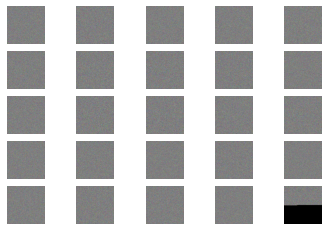

epoch: 2/100, disc_loss: 0.3920, gen_loss: 0.9549
epoch: 3/100, disc_loss: 0.4041, gen_loss: 0.9091
epoch: 4/100, disc_loss: 0.3973, gen_loss: 0.8691
epoch: 5/100, disc_loss: 0.3876, gen_loss: 0.8192
epoch: 6/100, disc_loss: 0.3713, gen_loss: 0.7653
epoch: 7/100, disc_loss: 0.3592, gen_loss: 0.7267
epoch: 8/100, disc_loss: 0.3511, gen_loss: 0.7026
epoch: 9/100, disc_loss: 0.3328, gen_loss: 0.6730
epoch: 10/100, disc_loss: 0.3309, gen_loss: 0.6612
epoch: 11/100, disc_loss: 0.3210, gen_loss: 0.6733
Fake Images at Epoch: 11/100


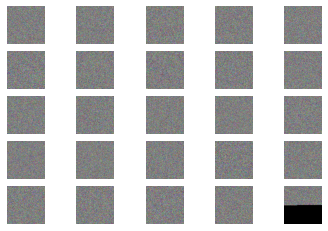

epoch: 12/100, disc_loss: 0.3306, gen_loss: 0.6617
epoch: 13/100, disc_loss: 0.3328, gen_loss: 0.6693
epoch: 14/100, disc_loss: 0.3385, gen_loss: 0.6688
epoch: 15/100, disc_loss: 0.3381, gen_loss: 0.6883
epoch: 16/100, disc_loss: 0.3359, gen_loss: 0.7014


KeyboardInterrupt: 

In [48]:
#create losses
discriminator_loss = []
generator_loss = []

# training
for epoch in range(EPOCHS):
    #get batches of real images
    index = np.random.randint(0, train_images.shape[0], BATCH_SIZE) ###################################
    real_images = train_images[index]
    
    #get fake images
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    fake_images = generator.predict(noise)
    
    #train 
    disc_loss_real, disc_acc_real = discriminator.train_on_batch(real_images, ONES)
    disc_loss_fake, disc_acc_fake = discriminator.train_on_batch(fake_images, ZEROS)
    disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
    disc_acc = 0.5 * (disc_loss_real + disc_loss_fake)
    
    #train generator 
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = GAN.train_on_batch(noise, ONES)
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = GAN.train_on_batch(noise, ZEROS)
    
    #save loss
    discriminator_loss.append(disc_loss)
    generator_loss.append(gen_loss)
    
    print(f"epoch: {epoch+1}/{EPOCHS}, disc_loss: {disc_loss:.4f}, gen_loss: {gen_loss:.4f}")
    
    if epoch % 10 == 0:
        print(f'Fake Images at Epoch: {epoch+1}/{EPOCHS}')
        sample_images(epoch)

In [ ]:
plt.plot(generator_loss, label='g_losses')
plt.plot(discriminator_loss, label='d_losses')
plt.legend();

# 4. Result 

It looks like our model learned something! Great! Since we can't submit the project anymore (past competition dates), we can't see how well our model is performing so far. However, we can see that the model started to get more browns and started to form some sort of shape-like figures. However, it is obvious these are not dogs, or anything like it. As a first GAN project, I'm satisified that the model was able to run and start to learn something. After 200 epochs and many hours of waiting for the model to train, I've decided this is as far as I'll take it for this mini-project. We can see that the model was learning and (hopefully) improving. During this project, I tried modifying many parts of the model to try and get a better outcome such as different activation functions, different momentum values, different number of Convolutional layers, and different values of dropout. In all, since these models take so long to train, I tried 3 different combinations of values and structure and this was the best result thus far. In the conclusion, we'll discuss ways to improve the model. 

In [ ]:
#save images in zip
z = zipfile.PyZipFile('images.zip', mode='w')

#save model
model_filename = 'generator_model.h5'
tf.keras.models.save_model(generator, model_filename, overwrite=True, include_optimizer=True, save_format=None)

# 5. Conclusion

Our model did learn and begin to take shape. However, it is obvious our model did not create convincing dog images. There are a few suggestions: increase the number of epochs, modify the architecture and/or try transfer learning. Something that I would have liked to try was transfer learning during the generator part so that the model doesn't have to learn from 0. In addition, I think increasing the number of epochs would have useful. As we can see in the generated images, we are just now starting to get more "dog-like" colors and begining to create shapes. GANs are complex models which require much patience and knowledge. This project just scrapes the surface of GANs and how much they can accomplish. 

For some cool inspiration for GANs and what they can do: https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/

  
   
.

.

.

.

.

.

.
       

This notebook was inspired from the Tensorflow website (https://www.tensorflow.org/tutorials/generative/dcgan) because this was my first GAN project and I needed guidance on how to make it work, as well as https://www.kaggle.com/code/jpdurham/tensorflow-dcgan and https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/.
